In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from scipy import stats
from tqdm import tqdm

from src.datasets.load_trees import load_trees_from_file
from src.distribution_analysis.process_tree import get_observed_nodes, get_clade_split_df
from src.utils.tree_utils import get_taxa_names

In [3]:
sns.set_style("darkgrid")

In [4]:
dict_true_tree_percentiles = {
    "true_length_percentile": [],
    "clade_split": [],
    "dataset": [],
    "num_occurrences": [],
    "true_branch_length": [],
    "sample_mean_branch_length": [],
}

for true_tree_path in tqdm(list(Path("data/mcmc_config").glob("yule-50_*.trees"))[:10]):
    true_tree = load_trees_from_file(true_tree_path)
    mcmc_trees = load_trees_from_file(Path("data/mcmc_runs") / true_tree_path.name)

    taxa_names = get_taxa_names(true_tree[0])

    _, observed_clade_splits_true = get_observed_nodes(true_tree, taxa_names)
    _, observed_clade_splits_mcmc = get_observed_nodes(mcmc_trees, taxa_names)

    df_clade_splits_true = get_clade_split_df(observed_clade_splits_true)   
    df_clade_splits_mcmc = get_clade_split_df(observed_clade_splits_mcmc)

    for _, true_clade_split in df_clade_splits_true.iterrows():
        clade_split = true_clade_split["clade_split"]
        true_length = true_clade_split["min_branch"]
        
        sample_lengths = df_clade_splits_mcmc[df_clade_splits_mcmc["clade_split"] == clade_split]["min_branch"].dropna()
        
        if len(sample_lengths) == 0: continue

        dict_true_tree_percentiles["true_length_percentile"].append(
            stats.percentileofscore(sample_lengths, true_length)
        )
        dict_true_tree_percentiles["clade_split"].append(clade_split)
        dict_true_tree_percentiles["dataset"].append(true_tree_path.name.removesuffix(".trees"))
        dict_true_tree_percentiles["num_occurrences"].append(len(sample_lengths))
        dict_true_tree_percentiles["true_branch_length"].append(true_length)
        dict_true_tree_percentiles["sample_mean_branch_length"].append(sample_lengths.mean())

df_dataset = pd.DataFrame(dict_true_tree_percentiles)

100%|██████████| 10/10 [12:28<00:00, 74.80s/it]


In [21]:
true_tree_path

PosixPath('data/mcmc_config/yule-50_22.trees')

Text(0.5, 0, 'Percentile of True Branch Length')

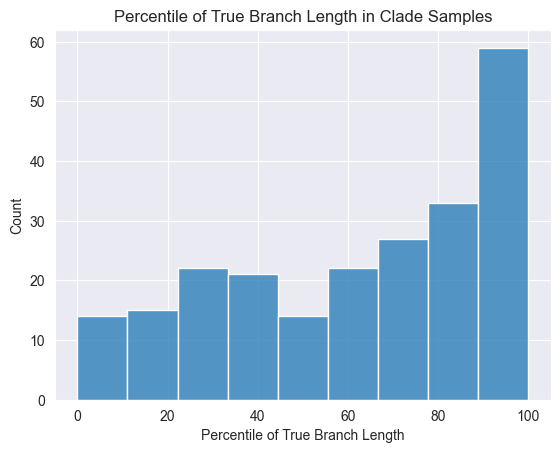

In [9]:
sns.histplot(
    df_dataset,
    x="true_length_percentile",
)

plt.title("Percentile of True Branch Length in Clade Samples")
plt.xlabel("Percentile of True Branch Length")

Text(0.5, 0, 'Number of Samples')

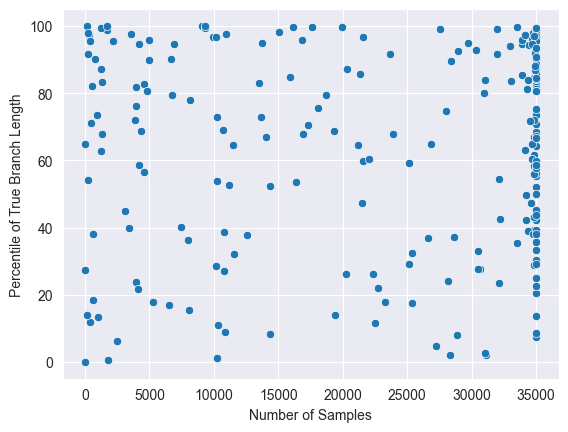

In [10]:
sns.scatterplot(
    df_dataset,
    x="num_occurrences",
    y="true_length_percentile",
)

plt.ylabel("Percentile of True Branch Length")
plt.xlabel("Number of Samples")

Text(0.5, 0, 'True Branch Length')

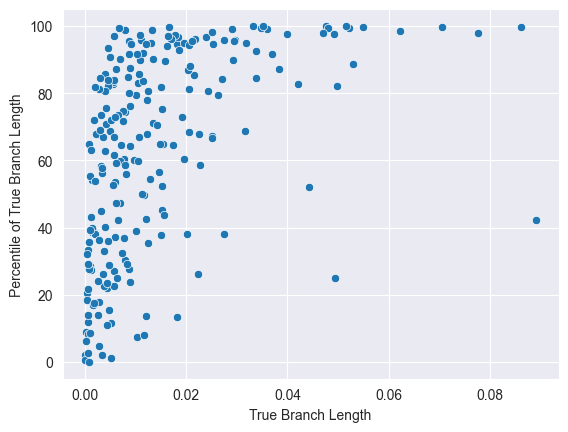

In [11]:
sns.scatterplot(
    df_dataset,
    x="true_branch_length",
    y="true_length_percentile",
)

plt.ylabel("Percentile of True Branch Length")
plt.xlabel("True Branch Length")

In [14]:
len(df_dataset)

227